In [ ]:
# Project Description: Customer Segmentation Using Unsupervised Learning
# This project performs advanced customer segmentation on the Online Retail dataset using unsupervised machine learning techniques. The workflow includes comprehensive data preprocessing, feature engineering (RFM analysis), and clustering algorithms (K-Means and DBSCAN) to identify distinct customer groups for targeted marketing strategies.
# Key steps:

# Data Cleaning: Handles missing values, removes cancelled orders, filters invalid entries, and eliminates duplicates.
# Feature Engineering: Calculates Recency, Frequency, and Monetary (RFM) metrics for each customer, scores and segments customers based on RFM values.
# Feature Scaling: Applies log transformation and standardization to prepare features for clustering.
# Clustering: Uses K-Means (with elbow and silhouette methods for optimal cluster selection) and DBSCAN to segment customers.
# Evaluation: Assesses clustering performance using metrics like Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index.
# Visualization: Employs PCA for dimensionality reduction and visualizes clusters and RFM distributions.
# Business Insights: Profiles each cluster and generates actionable business recommendations for customer engagement and retention.
# Results Saving: Exports cluster assignments, summaries, and metrics to CSV files for further analysis.
# This project enables data-driven customer segmentation, helping businesses tailor marketing campaigns, improve customer retention, and maximize revenue.



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Text Processing (for product descriptions)
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [ ]:
#Loading Data
try:
    df = pd.read_excel('Online Retail.xlsx')
    print("✓ Data loaded from local file")
except:
    # Method 2: Load from CSV if you've converted it
    try:
        df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')
        print("✓ Data loaded from CSV file")
    except:
        print("⚠ Please download the dataset from UCI ML Repository")
        print("Link: https://archive.ics.uci.edu/ml/datasets/online+retail")


✓ Data loaded from local file


In [ ]:
# Display basic information of Data
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

# Display first few rows
print("\nFirst 5 rows:")
df.head()


Dataset Shape: (541909, 8)
Rows: 541,909 | Columns: 8

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#EDA
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check missing values
print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

# Basic statistics
print("\nBasic Statistics:")
df.describe()

# Check unique values
print(f"\nNumber of Unique Customers: {df['CustomerID'].nunique()}")
print(f"Number of Unique Products: {df['StockCode'].nunique()}")
print(f"Number of Unique Invoices: {df['InvoiceNo'].nunique()}")
print(f"Number of Countries: {df['Country'].nunique()}")

# Date range
print(f"\nDate Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")



EXPLORATORY DATA ANALYSIS

Data Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing Values:
             Missing_Count  Percentage
Description           1454    0.268311
CustomerID          135080   24.926694

Basic Statistics:

Number of Unique Customers: 4372
Number of Unique Products: 4070
Number of Unique Invoices: 25900
Number of Countries: 38

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
#Data Preprocessing
print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
df_clean = df.copy()

# 4.1 Remove missing CustomerID (essential for segmentation)
print(f"\nBefore removing NaN CustomerID: {len(df_clean)}")
df_clean = df_clean.dropna(subset=['CustomerID'])
print(f"After removing NaN CustomerID: {len(df_clean)}")

# 4.2 Remove cancelled orders (InvoiceNo starting with 'C')
print(f"\nBefore removing cancellations: {len(df_clean)}")
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancellations: {len(df_clean)}")

# 4.3 Remove invalid quantities and prices
print(f"\nBefore removing invalid quantities/prices: {len(df_clean)}")
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"After removing invalid entries: {len(df_clean)}")

# 4.4 Remove duplicate rows
print(f"\nBefore removing duplicates: {len(df_clean)}")
df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {len(df_clean)}")

# 4.5 Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 4.6 Create TotalCost feature
df_clean['TotalCost'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 4.7 Handle outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from Quantity and UnitPrice
print(f"\nBefore outlier removal: {len(df_clean)}")
df_clean = remove_outliers_iqr(df_clean, 'Quantity')
df_clean = remove_outliers_iqr(df_clean, 'UnitPrice')
df_clean = remove_outliers_iqr(df_clean, 'TotalCost')
print(f"After outlier removal: {len(df_clean)}")

print("\n✓ Data preprocessing completed!")
print(f"Final dataset shape: {df_clean.shape}")


DATA PREPROCESSING

Before removing NaN CustomerID: 541909
After removing NaN CustomerID: 406829

Before removing cancellations: 406829
After removing cancellations: 397924

Before removing invalid quantities/prices: 397924
After removing invalid entries: 397884

Before removing duplicates: 397884
After removing duplicates: 392692

Before outlier removal: 392692
After outlier removal: 319806

✓ Data preprocessing completed!
Final dataset shape: (319806, 9)



RFM ANALYSIS
Snapshot Date: 2011-12-10

RFM Statistics:
         CustomerID      Recency    Frequency      Monetary
count   4146.000000  4146.000000  4146.000000   4146.000000
mean   15296.229378    93.181380     3.918234    845.536065
std     1718.519565   100.015984     6.813902   1761.718973
min    12347.000000     1.000000     1.000000      1.700000
25%    13819.500000    18.000000     1.000000    171.970000
50%    15290.500000    51.000000     2.000000    402.440000
75%    16775.750000   145.000000     4.000000    957.142500
max    18287.000000   374.000000   193.000000  70372.020000


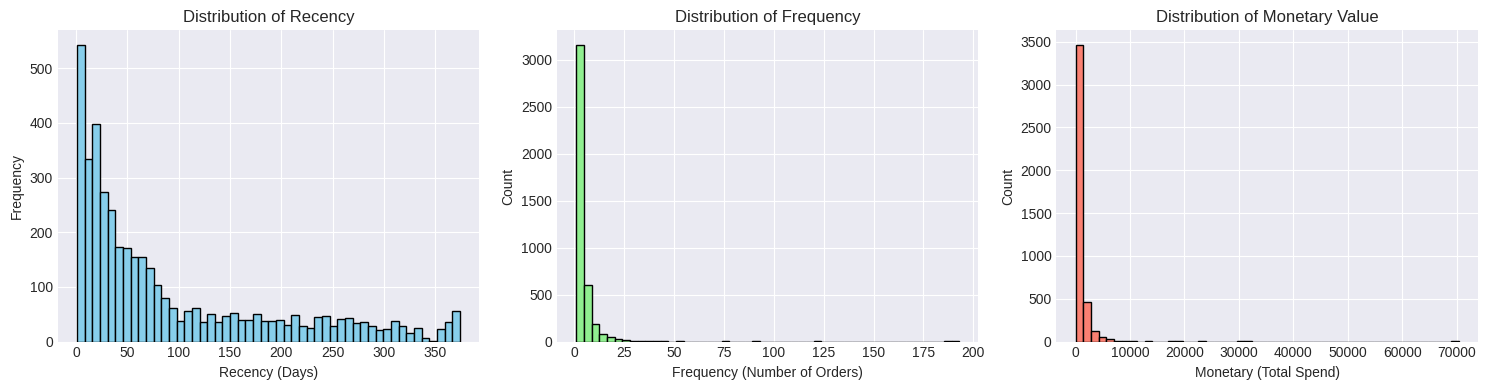

In [ ]:
#Feature Engineering
print("\n" + "="*60)
print("RFM ANALYSIS")
print("="*60)

# Define reference date (1 day after the last transaction)
snapshot_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"Snapshot Date: {snapshot_date.date()}")

# Create RFM features
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalCost': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nRFM Statistics:")
print(rfm.describe())

# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Recency (Days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Recency')

axes[1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Frequency (Number of Orders)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Frequency')

axes[2].hist(rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
axes[2].set_xlabel('Monetary (Total Spend)')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Monetary Value')

plt.tight_layout()
plt.show()


RFM SCORING

Customer Distribution by RFM Level:
RFM_Level
At Risk                1101
Potential Customers    1037
Loyal Customers         944
Best Customers          899
Lost Customers          165
Name: count, dtype: int64


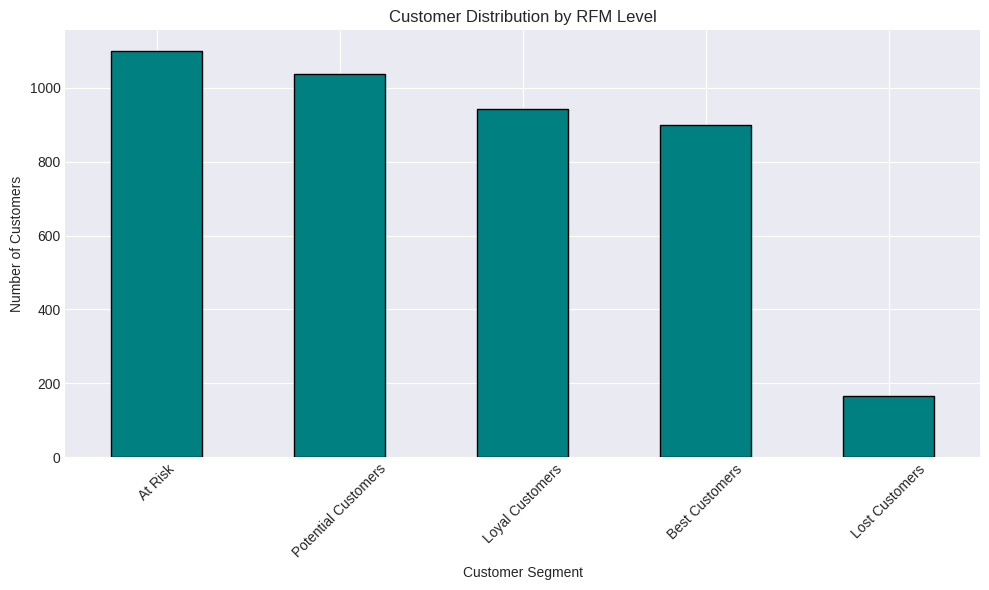

In [ ]:
#RFM Scoring
print("\n" + "="*60)
print("RFM SCORING")
print("="*60)

# Create RFM Scores (1-5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Convert to numeric
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create RFM Score (combination)
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Create RFM Segment String
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Define customer segments based on RFM scores
def rfm_level(df):
    if df['RFM_Score'] >= 13:
        return 'Best Customers'
    elif df['RFM_Score'] >= 10:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 7:
        return 'Potential Customers'
    elif df['RFM_Score'] >= 4:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)

# Display RFM Level distribution
print("\nCustomer Distribution by RFM Level:")
print(rfm['RFM_Level'].value_counts())

# Visualize RFM Levels
plt.figure(figsize=(10, 6))
rfm['RFM_Level'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution by RFM Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Scaling Features
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Select features for clustering
features_for_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Handle any remaining outliers using log transformation
features_for_clustering['Recency'] = np.log1p(features_for_clustering['Recency'])
features_for_clustering['Frequency'] = np.log1p(features_for_clustering['Frequency'])
features_for_clustering['Monetary'] = np.log1p(features_for_clustering['Monetary'])

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

print("✓ Features scaled successfully!")
print(f"Scaled features shape: {features_scaled.shape}")



FEATURE SCALING
✓ Features scaled successfully!
Scaled features shape: (4146, 3)



DETERMINING OPTIMAL NUMBER OF CLUSTERS


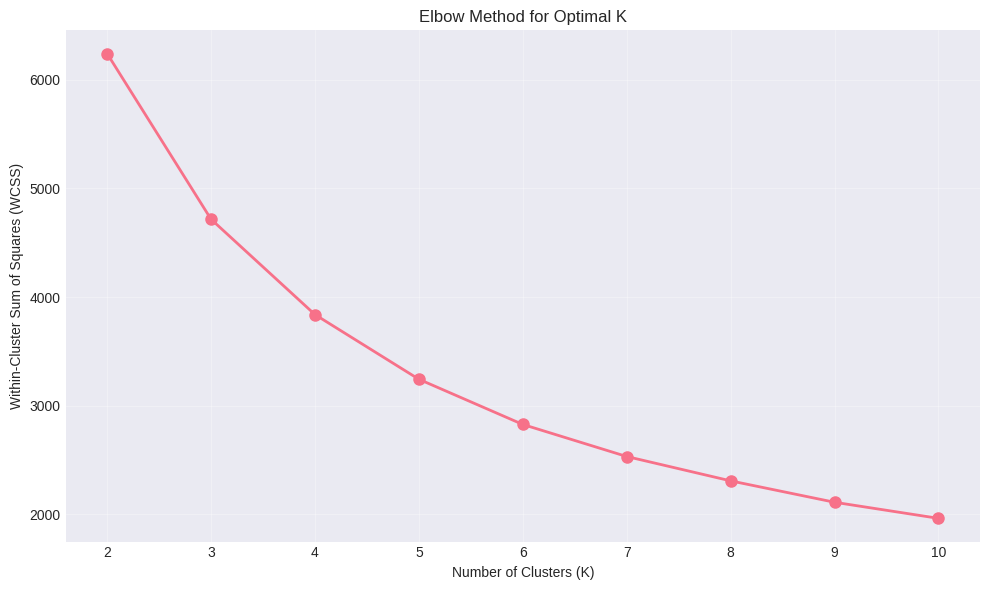

K=2: Silhouette Score = 0.4254
K=3: Silhouette Score = 0.3252
K=4: Silhouette Score = 0.3265
K=5: Silhouette Score = 0.2888
K=6: Silhouette Score = 0.2909
K=7: Silhouette Score = 0.2857
K=8: Silhouette Score = 0.2823
K=9: Silhouette Score = 0.2883
K=10: Silhouette Score = 0.2805


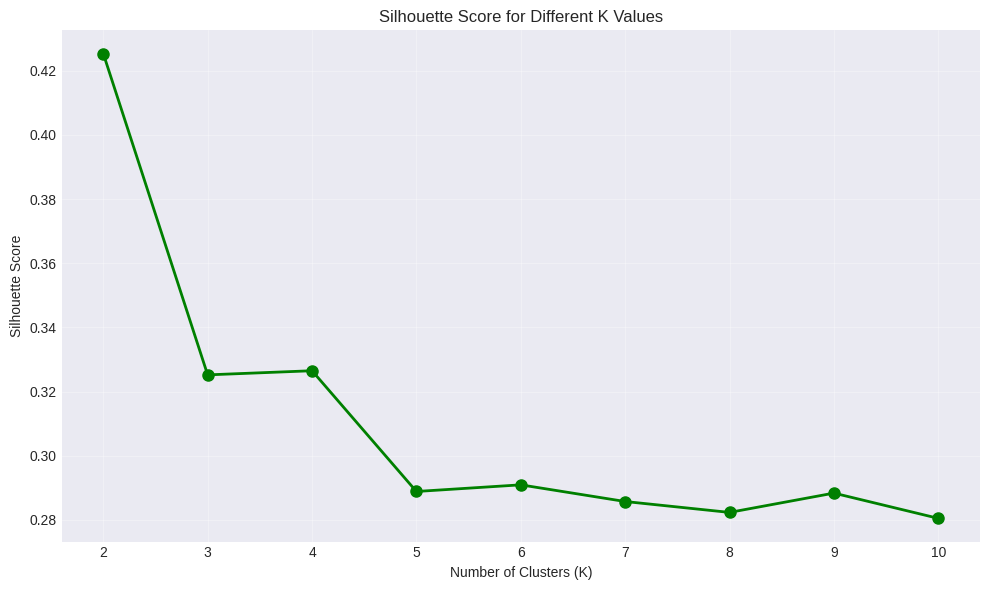


✓ Optimal number of clusters: 2
   Silhouette Score: 0.4254


In [ ]:
#Determining Number of Clusters
print("\n" + "="*60)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

# Method 1: Elbow Method (WCSS)
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Method 2: Silhouette Score
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find optimal K based on highest silhouette score
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✓ Optimal number of clusters: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.4f}")

In [ ]:
#K-Means Clustering
print("\n" + "="*60)
print(f"K-MEANS CLUSTERING (K={optimal_k})")
print("="*60)

# Apply K-Means with optimal K
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
rfm['Cluster'] = kmeans_final.fit_predict(features_scaled)

print("✓ K-Means clustering completed!")


K-MEANS CLUSTERING (K=2)
✓ K-Means clustering completed!


In [ ]:
#Evaluating Cluster Performance
print("\n" + "="*60)
print("CLUSTERING PERFORMANCE METRICS")
print("="*60)

# Calculate performance metrics
silhouette_avg = silhouette_score(features_scaled, rfm['Cluster'])
calinski_harabasz = calinski_harabasz_score(features_scaled, rfm['Cluster'])
davies_bouldin = davies_bouldin_score(features_scaled, rfm['Cluster'])

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
    'Score': [silhouette_avg, calinski_harabasz, davies_bouldin],
    'Interpretation': [
        'Higher is better (range: -1 to 1)',
        'Higher is better',
        'Lower is better'
    ]
})

print("\n")
print(metrics_df.to_string(index=False))


CLUSTERING PERFORMANCE METRICS


                 Metric       Score                    Interpretation
       Silhouette Score    0.425390 Higher is better (range: -1 to 1)
Calinski-Harabasz Index 4114.362180                  Higher is better
   Davies-Bouldin Index    0.901153                   Lower is better



CLUSTER CHARACTERISTICS


         Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count  Percentage
Cluster                                                                      
0              26.88           7.55       1725.02            1620       39.07
1             135.70           1.59        281.50            2526       60.93


              Segment_Name  Customer_Count  Percentage
Cluster                                               
0          Loyal Customers            1620       39.07
1        At Risk / Churned            2526       60.93


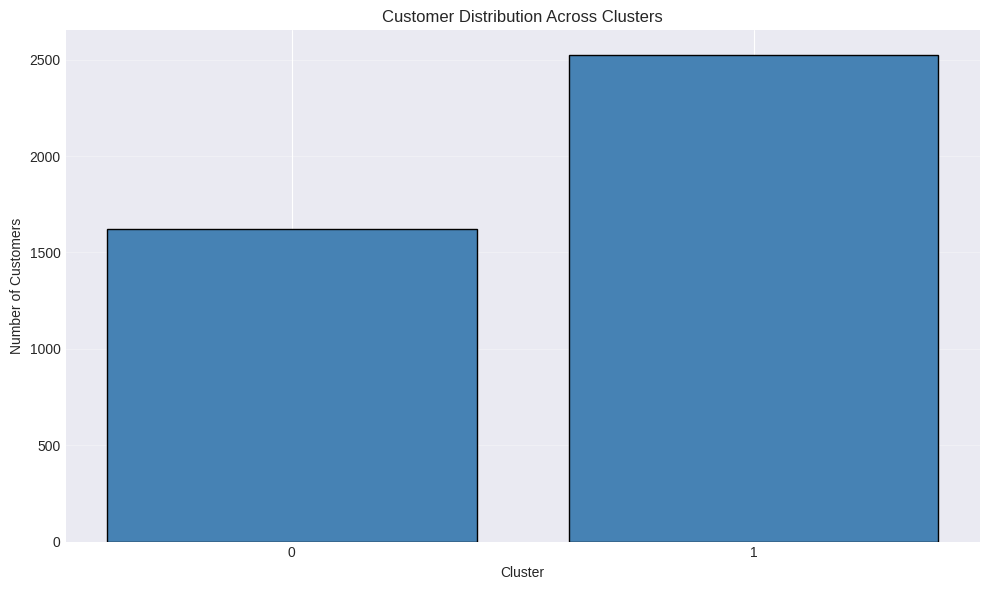

In [ ]:
#Clusters Analysis and Interpretation
print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS")
print("="*60)

# Analyze cluster characteristics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
cluster_summary['Percentage'] = (cluster_summary['Customer_Count'] / cluster_summary['Customer_Count'].sum() * 100).round(2)

print("\n")
print(cluster_summary)

# Assign meaningful names to clusters
def name_cluster(row):
    if row['Avg_Recency'] < 50 and row['Avg_Frequency'] > 10 and row['Avg_Monetary'] > 2000:
        return 'Best Customers'
    elif row['Avg_Recency'] < 100 and row['Avg_Frequency'] > 5:
        return 'Loyal Customers'
    elif row['Avg_Recency'] < 50 and row['Avg_Frequency'] < 5:
        return 'New Customers'
    elif row['Avg_Recency'] > 100:
        return 'At Risk / Churned'
    else:
        return 'Average Customers'

cluster_summary['Segment_Name'] = cluster_summary.apply(name_cluster, axis=1)

print("\n")
print(cluster_summary[['Segment_Name', 'Customer_Count', 'Percentage']])

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
plt.bar(cluster_summary.index, cluster_summary['Customer_Count'], color='steelblue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution Across Clusters')
plt.xticks(cluster_summary.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


DIMENSIONALITY REDUCTION AND VISUALIZATION

Explained Variance Ratio:
PC1: 73.72%
PC2: 18.43%
Total: 92.15%


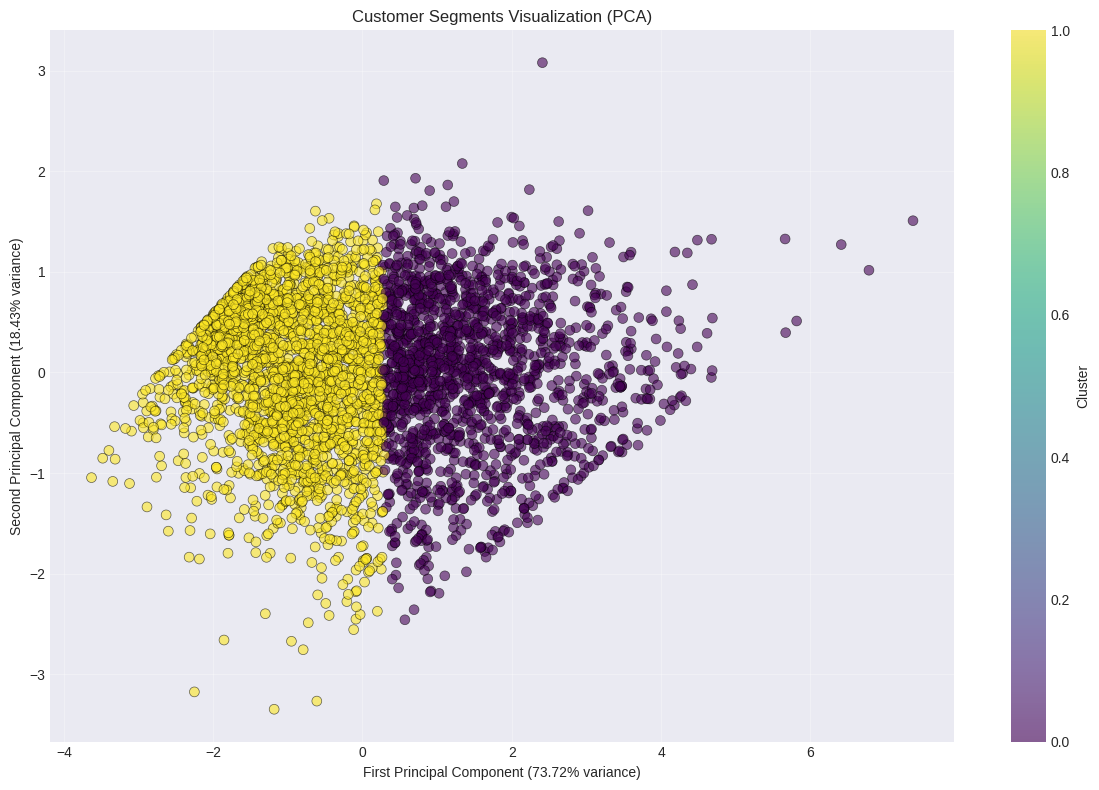

In [ ]:
#Visualizing using PCA
print("\n" + "="*60)
print("DIMENSIONALITY REDUCTION AND VISUALIZATION")
print("="*60)

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# Add PCA components to dataframe
rfm['PCA1'] = features_pca[:, 0]
rfm['PCA2'] = features_pca[:, 1]

print(f"\nExplained Variance Ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {pca.explained_variance_ratio_.sum():.2%}")

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Cluster'],
                     cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Segments Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


DETAILED CLUSTER PROFILING


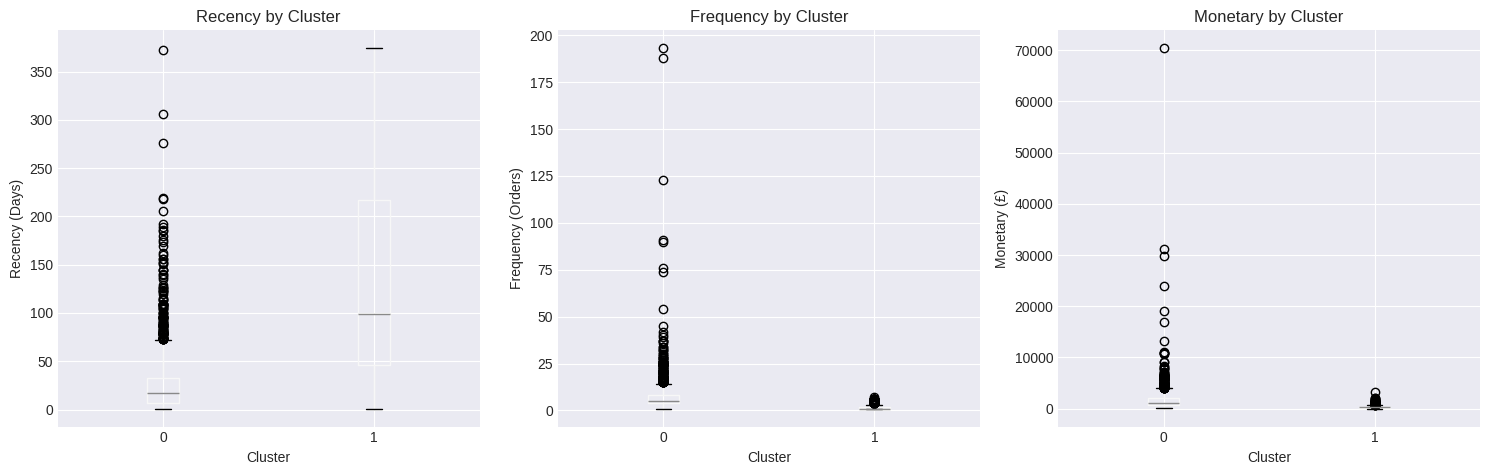

In [ ]:
#Clusters Profile
print("\n" + "="*60)
print("DETAILED CLUSTER PROFILING")
print("="*60)

# Create box plots for RFM features by cluster
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

rfm.boxplot(column='Recency', by='Cluster', ax=axes[0])
axes[0].set_title('Recency by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Recency (Days)')

rfm.boxplot(column='Frequency', by='Cluster', ax=axes[1])
axes[1].set_title('Frequency by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency (Orders)')

rfm.boxplot(column='Monetary', by='Cluster', ax=axes[2])
axes[2].set_title('Monetary by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary (£)')

plt.suptitle('')  # Remove default suptitle
plt.tight_layout()
plt.show()


In [ ]:
#Business Recommendation
print("\n" + "="*60)
print("BUSINESS RECOMMENDATIONS BY CLUSTER")
print("="*60)

# Create recommendations dictionary
recommendations = {
    'Best Customers': [
        '🎯 VIP treatment and exclusive access to new products',
        '💎 Premium customer service and personalized attention',
        '🎁 Loyalty rewards and special discounts',
        '📧 First access to sales and promotions'
    ],
    'Loyal Customers': [
        '🌟 Referral programs and incentives',
        '🎊 Regular engagement through newsletters',
        '💳 Special member-only offers',
        '📱 Mobile app exclusive features'
    ],
    'New Customers': [
        '👋 Welcome email series and onboarding',
        '🎉 First purchase discount for next order',
        '📚 Educational content about products',
        '🔔 Follow-up after first purchase'
    ],
    'Average Customers': [
        '📈 Cross-sell and upsell campaigns',
        '🎯 Product recommendations based on history',
        '💰 Bundle deals and limited-time offers',
        '⭐ Request reviews and feedback'
    ],
    'At Risk / Churned': [
        '🚨 Win-back campaigns with aggressive discounts',
        '📞 Personal outreach to understand concerns',
        '🎁 Special comeback offers',
        '📊 Exit surveys to learn why they left'
    ]
}

for segment, actions in recommendations.items():
    print(f"\n{segment}:")
    for action in actions:
        print(f"  {action}")


BUSINESS RECOMMENDATIONS BY CLUSTER

Best Customers:
  🎯 VIP treatment and exclusive access to new products
  💎 Premium customer service and personalized attention
  🎁 Loyalty rewards and special discounts
  📧 First access to sales and promotions

Loyal Customers:
  🌟 Referral programs and incentives
  🎊 Regular engagement through newsletters
  💳 Special member-only offers
  📱 Mobile app exclusive features

New Customers:
  👋 Welcome email series and onboarding
  🎉 First purchase discount for next order
  📚 Educational content about products
  🔔 Follow-up after first purchase

Average Customers:
  📈 Cross-sell and upsell campaigns
  🎯 Product recommendations based on history
  💰 Bundle deals and limited-time offers
  ⭐ Request reviews and feedback

At Risk / Churned:
  🚨 Win-back campaigns with aggressive discounts
  📞 Personal outreach to understand concerns
  🎁 Special comeback offers
  📊 Exit surveys to learn why they left


In [ ]:
#Saving Results
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save RFM with cluster assignments
rfm.to_csv('customer_segments.csv', index=False)
print("✓ Customer segments saved to 'customer_segments.csv'")

# Save cluster summary
cluster_summary.to_csv('cluster_summary.csv')
print("✓ Cluster summary saved to 'cluster_summary.csv'")

# Save performance metrics
metrics_df.to_csv('clustering_metrics.csv', index=False)
print("✓ Clustering metrics saved to 'clustering_metrics.csv'")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\n✅ Customer segmentation analysis completed successfully!")
print(f"   - Identified {optimal_k} distinct customer segments")
print(f"   - Silhouette Score: {silhouette_avg:.4f}")
print(f"   - Total Customers Analyzed: {len(rfm):,}")
print("\n📊 Results saved to CSV files for further analysis")
print("🎯 Business recommendations generated for each segment")


SAVING RESULTS
✓ Customer segments saved to 'customer_segments.csv'
✓ Cluster summary saved to 'cluster_summary.csv'
✓ Clustering metrics saved to 'clustering_metrics.csv'

ANALYSIS COMPLETE!

✅ Customer segmentation analysis completed successfully!
   - Identified 2 distinct customer segments
   - Silhouette Score: 0.4254
   - Total Customers Analyzed: 4,146

📊 Results saved to CSV files for further analysis
🎯 Business recommendations generated for each segment
